Checking for missing values...
los_icu    10
dtype: int64


=== Training Logistic Regression ===


/root/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/root/miniconda3/envs/myenv/lib/python3.10/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


Accuracy: 0.9425
Confusion Matrix:
 [[10972   631]
 [   71   535]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97     11603
           1       0.46      0.88      0.60       606

    accuracy                           0.94     12209
   macro avg       0.73      0.91      0.79     12209
weighted avg       0.97      0.94      0.95     12209



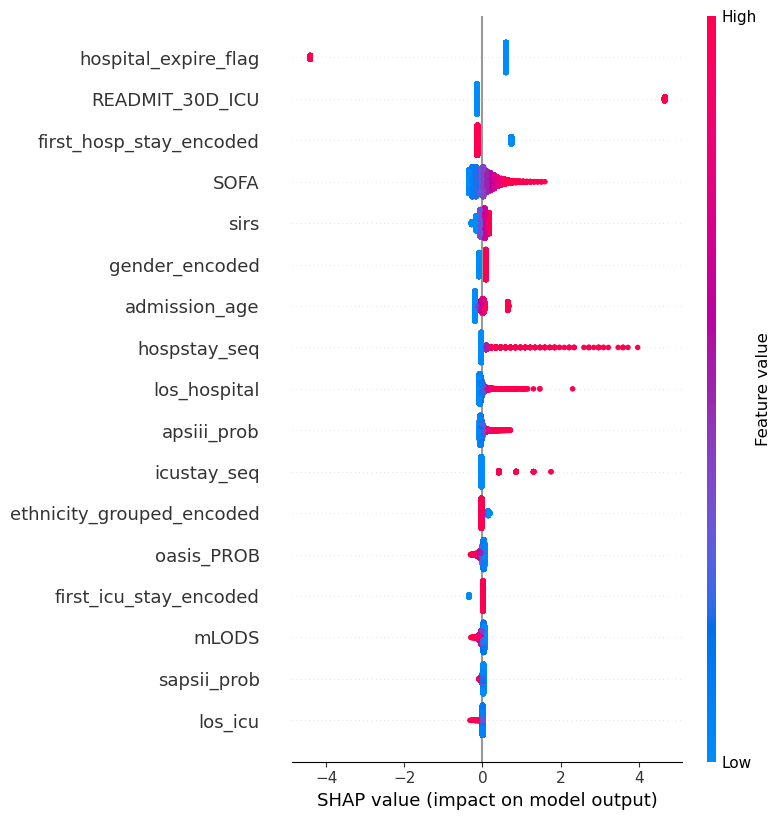

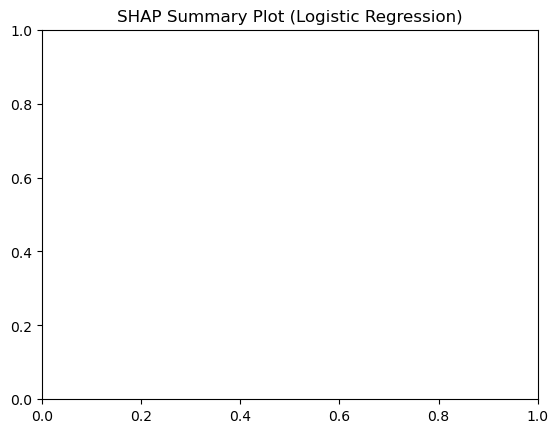



=== Training Random Forest ===
Accuracy: 0.9509
Confusion Matrix:
 [[11086   517]
 [   82   524]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97     11603
           1       0.50      0.86      0.64       606

    accuracy                           0.95     12209
   macro avg       0.75      0.91      0.81     12209
weighted avg       0.97      0.95      0.96     12209



AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 1200x800 with 0 Axes>

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
import shap
import matplotlib.pyplot as plt

# === 1. Load Your Data ===
df = pd.read_csv("ICU_scores.csv")

# Remove unnecessary unnamed column if present
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

# Define your features and target
TARGET = 'READMIT_30D'
FEATURES_TO_DROP = ['subject_id', 'hadm_id', 'icustay_id', 'READMIT_30D']

# Check for missing values before proceeding
print("Checking for missing values...")
missing_counts = df.isnull().sum()
print(missing_counts[missing_counts > 0])

# Apply dropna to clean any remaining NaN values
df_cleaned = df.dropna()

# Prepare data
X = df_cleaned.drop(columns=FEATURES_TO_DROP).values
y = df_cleaned[TARGET].values
feature_names = df_cleaned.drop(columns=FEATURES_TO_DROP).columns.tolist()

# === 2. Imputation to Handle Any Possible NaNs ===
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)  # Ensure no NaNs in the data

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# === 3. Define Models to Test ===
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, class_weight='balanced')
}

# === 4. Train, Evaluate, and Generate SHAP Plots for Each Model ===
for model_name, model in models.items():
    print(f"\n\n=== Training {model_name} ===")
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    # === SHAP Analysis ===
    if model_name == 'Logistic Regression':
        explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
        shap_values = explainer.shap_values(X_test)
        shap_title = "SHAP Summary Plot (Logistic Regression)"
        
    elif model_name == 'Random Forest':
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)[1]  # Select positive class (1) for classification problems
        shap_title = "SHAP Summary Plot (Random Forest)"
    
    # Plot SHAP summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test, feature_names=feature_names)
    plt.title(shap_title)
    plt.show()